# Task 1.4 Feature analysis   

Question: what is the right way to plot chi square test result

- compute correlation between features
- detect highly correlated features -> potential redundant features
- rank importance of features 

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np


pd.set_option('display.max_columns', None) # show full dataframe


### Functions

In [46]:
### Cramer V test

def cramerV(label,x):
    confusion_matrix = pd.crosstab(label, x)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r,k = confusion_matrix.shape
    phi2 = chi2/n
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r - 1) ** 2) / ( n - 1 )
    kcorr = k - ((k - 1) ** 2) / ( n - 1 )
    try:
        if min((kcorr - 1),(rcorr - 1)) == 0:
            warnings.warn(
            "Unable to calculate Cramer's V using bias correction. Consider not using bias correction",RuntimeWarning)
            v = 0
            print("If condition Met: ",v)
        else:
            v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
            print("Else condition Met: ",v)
    except:
        print("inside error")
        v = 0
    return v


def plot_cramer(df):
    cramer = pd.DataFrame(index=df.columns,columns=df.columns)
    for column_of_interest in df.columns:
        try:
            temp = {}

            columns = df.columns
            for j in range(0,len(columns)):
                v = cramerV(df[column_of_interest],df[columns[j]])
                cramer.loc[column_of_interest,columns[j]] = v
                if (column_of_interest==columns[j]):
                    pass
                else:
                    temp[columns[j]] = v
            cramer.fillna(value=np.nan,inplace=True)
        except:
            print('Dropping row:',column_of_interest)
            pass
    plt.figure(figsize=(7,7))
    sns.heatmap(cramer,annot=True,fmt='.2f')

    plt.title("Cross Correlation plot on Dataframe with Cramer's Correlation Values")
    plt.show()
  

In [47]:
def chi_square_test_on_functionality(df: pd.DataFrame) -> pd.DataFrame:
    
    """ Calculate correlation values and p-values to see if each column is independent from status_group.
        
        Hypothesis H0: feature X is not indpendent with status_group  
        Hypothesis H1: feature X is independent with status_group

        If p-value < 0.05, H0 is rejected.   
        feature X can be each categorical feature.    
    """
    
    ### create dataframe only with categorical data
    df_categorical= pd.DataFrame(data = df.dtypes, columns = ['a']).reset_index()

    categorical_variables = list(df_categorical['index'].loc[df_categorical['a'] == 'object'])
    df_categorical = df[categorical_variables]

    print(df_categorical.shape)



    ### perform chi square test

    # reference: https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables

    # factors_paired = [(i,j) for i in df_categorical.columns.values for j in df_categorical.columns.values] 

    chi2, p_values =[], []

    for f in df_categorical.columns:
        chitest = chi2_contingency(pd.crosstab(df_categorical[f], df_categorical["status_group"]))   
        chi2.append(chitest[0])
        p_values.append(chitest[1])

    # chi2 = np.array(chi2).reshape((23,23)) # shape it as a matrix


    ### format the test result in pandas dataframe

    chi2_df = pd.DataFrame(chi2, index=df_categorical.columns, columns=["status_group"]) # then a df for convenience
    pvalues_df = pd.DataFrame(p_values, index=df_categorical.columns, columns=["status_group"]) # then a df for convenience
    
    return chi2_df, pvalues_df

In [48]:
def numerical_feature_heatmap(df: pd.DataFrame):
    # Compute correlation matrix
    co_mtx = df.corr(numeric_only=True)

    # Plot correlation heatmap
    sns.heatmap(co_mtx, cmap="YlGnBu", annot=False, linewidths=0.3, linecolor='gray', xticklabels=True, yticklabels=True)

    sns.set_theme(rc={'figure.figsize':(12,10)})


### Import data

In [49]:
# import data
train_val = pd.read_csv("../data/training_set_values.csv")
train_label = pd.read_csv("../data/training_set_labels.csv")

In [50]:
# merge train_set_values and train_set_labels on ID
train_data = pd.merge(train_val, train_label, on="id")

### Analyze features

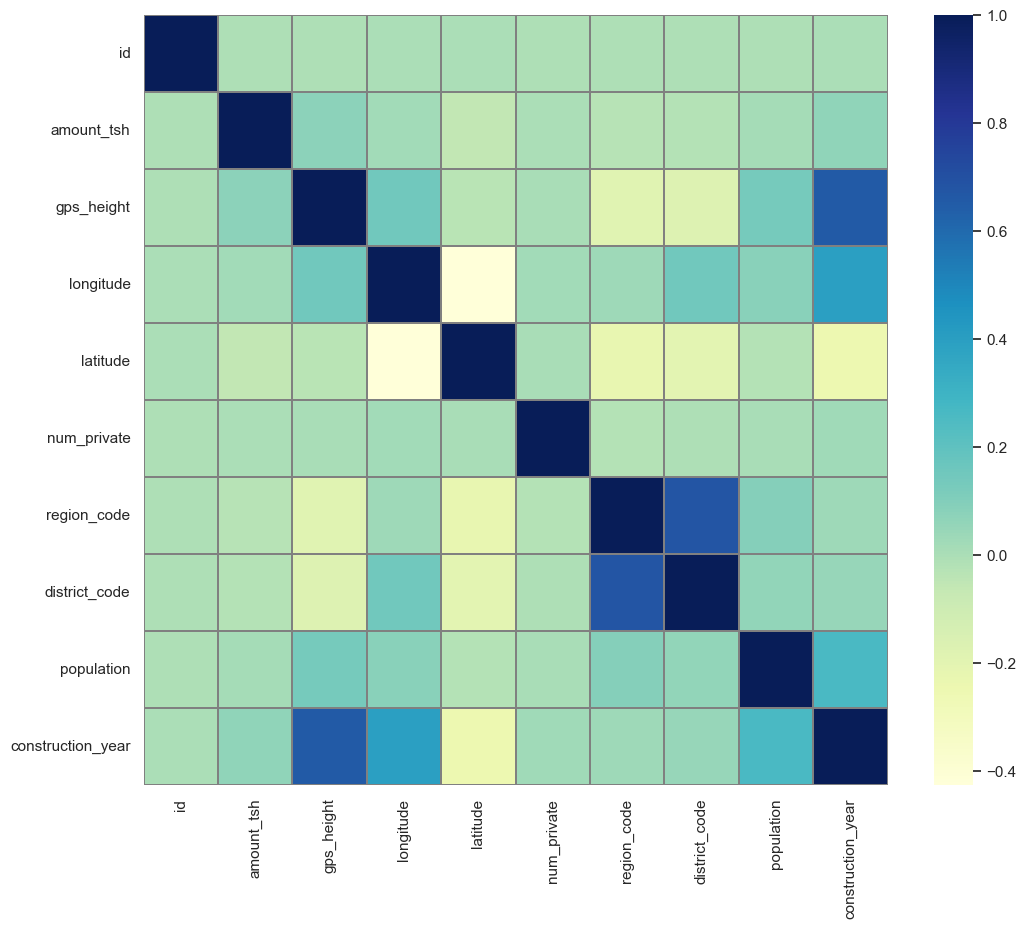

In [51]:
numerical_feature_heatmap(train_data)

In [52]:
# drop_columns = ["id", "date_recorded", "funder", "installer", "wpt_name", "subvillage", "ward",
#                 "public_meeting", "recorded_by", "scheme_name"]

# duplicated_columns = ["extraction_type", "management_group", "payment_type",
#                      "quantity_group", "source_type"]

# categorical_columns = ["basin", "region", "lga", "scheme_management", "permit",
#                         "extraction_type_group", "extraction_type_class",
#                        "management", "payment",
#                        "water_quality",  "quality_group", "quantity", "source", "source_class",
#                        "waterpoint_type", "waterpoint_type_group", "status_group"]

### show source, extraction_type, and waterpoint_type_group are correlated

In [53]:
# show source, extraction_type, and waterpoint_type_group are correlated

features = ["source", "source_type",
            "extraction_type", "extraction_type_class", "extraction_type_group", 
            "waterpoint_type", "waterpoint_type_group", 
            "status_group"]

df1 = train_data[features]
df1

,source,source_type,extraction_type,extraction_type_class,extraction_type_group,waterpoint_type,waterpoint_type_group,status_group
0,spring,spring,gravity,gravity,gravity,communal standpipe,communal standpipe,functional
1,rainwater harvesting,rainwater harvesting,gravity,gravity,gravity,communal standpipe,communal standpipe,functional
2,dam,dam,gravity,gravity,gravity,communal standpipe multiple,communal standpipe,functional
3,machine dbh,borehole,submersible,submersible,submersible,communal standpipe multiple,communal standpipe,non functional
4,rainwater harvesting,rainwater harvesting,gravity,gravity,gravity,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...
59395,spring,spring,gravity,gravity,gravity,communal standpipe,communal standpipe,functional
59396,river,river/lake,gravity,gravity,gravity,communal standpipe,communal standpipe,functional
59397,machine dbh,borehole,swn 80,handpump,swn 80,hand pump,hand pump,functional
59398,shallow well,shallow well,nira/tanira,handpump,nira/tanira,hand pump,hand pump,functional


In [54]:
chi_df1, pvalue_df1 = chi_square_test_on_functionality(df1)

pvalue_df1

(59400, 8)


,status_group
source,0.0
source_type,0.0
extraction_type,0.0
extraction_type_class,0.0
extraction_type_group,0.0
waterpoint_type,0.0
waterpoint_type_group,0.0
status_group,0.0


Else condition Met:  1.0
Else condition Met:  0.9999747441795817
Else condition Met:  0.4075796469624362
Else condition Met:  0.45477436688715256
Else condition Met:  0.3928718162709593
Else condition Met:  0.3790432604502636
Else condition Met:  0.384513017706805
Else condition Met:  0.14811059560973563
Else condition Met:  0.9999747441795815
Else condition Met:  1.0
Else condition Met:  0.4828792399858035
Else condition Met:  0.4395269621326449


C:\Users\Owner\AppData\Local\Temp\ipykernel_14316\2193547950.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramer.fillna(value=np.nan,inplace=True)


Else condition Met:  0.46496126258983417
Else condition Met:  0.36686941003835283
Else condition Met:  0.3796411921416782
Else condition Met:  0.12629334316907617
Else condition Met:  0.4075796469624362
Else condition Met:  0.4828792399858035
Else condition Met:  1.0
Else condition Met:  0.9999073922064348
Else condition Met:  0.9999579023587122
Else condition Met:  0.5050695695546932
Else condition Met:  0.5366675351030793
Else condition Met:  0.24842745816693432
Else condition Met:  0.45477436688715256
Else condition Met:  0.4395269621326449
Else condition Met:  0.9999073922064345
Else condition Met:  1.0
Else condition Met:  0.9999494877212747
Else condition Met:  0.5042971744032346
Else condition Met:  0.5364634404664221
Else condition Met:  0.24133876082175432
Else condition Met:  0.3928718162709593
Else condition Met:  0.46496126258983417
Else condition Met:  0.9999579023587122
Else condition Met:  0.9999494877212747
Else condition Met:  1.0
Else condition Met:  0.504359808894990

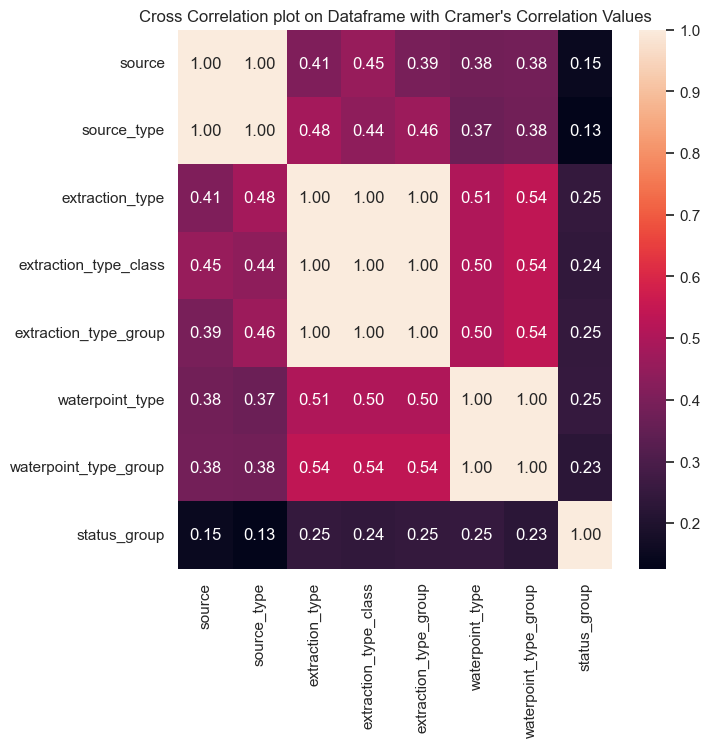

In [55]:
plot_cramer(df1) 

### Payment, quality, quantity

In [57]:
features = ["payment", "payment_type",
            "water_quality", "quality_group", 
            "quantity","quantity_group",
            "status_group"]

df2 = train_data[features]
df2

,payment,payment_type,water_quality,quality_group,quantity,quantity_group,status_group
0,pay annually,annually,soft,good,enough,enough,functional
1,never pay,never pay,soft,good,insufficient,insufficient,functional
2,pay per bucket,per bucket,soft,good,enough,enough,functional
3,never pay,never pay,soft,good,dry,dry,non functional
4,never pay,never pay,soft,good,seasonal,seasonal,functional
...,...,...,...,...,...,...,...
59395,pay per bucket,per bucket,soft,good,enough,enough,functional
59396,pay annually,annually,soft,good,enough,enough,functional
59397,pay monthly,monthly,fluoride,fluoride,enough,enough,functional
59398,never pay,never pay,soft,good,insufficient,insufficient,functional


In [58]:
chi_df2, pvalue_df2 = chi_square_test_on_functionality(df2)

pvalue_df2

(59400, 7)


,status_group
payment,0.0
payment_type,0.0
water_quality,0.0
quality_group,0.0
quantity,0.0
quantity_group,0.0
status_group,0.0


Else condition Met:  1.0
Else condition Met:  1.0
Else condition Met:  0.13328145820808104
Else condition Met:  0.14292689190176272
Else condition Met:  0.12706207544850687
Else condition Met:  0.12706207544850687
Else condition Met:  0.18243010577935334
Else condition Met:  1.0
Else condition Met:  1.0
Else condition Met:  0.13328145820808104
Else condition Met:  0.14292689190176272
Else condition Met:  0.12706207544850687
Else condition Met:  0.12706207544850687
Else condition Met:  0.18243010577935334
Else condition Met:  0.13328145820808104


C:\Users\Owner\AppData\Local\Temp\ipykernel_14316\2193547950.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramer.fillna(value=np.nan,inplace=True)


Else condition Met:  0.13328145820808104
Else condition Met:  1.0
Else condition Met:  0.9999831631407464
Else condition Met:  0.280286124629058
Else condition Met:  0.280286124629058
Else condition Met:  0.13803116928255116
Else condition Met:  0.14292689190176275
Else condition Met:  0.14292689190176275
Else condition Met:  0.9999831631407465
Else condition Met:  0.9999999999999999
Else condition Met:  0.27945514378507375
Else condition Met:  0.27945514378507375
Else condition Met:  0.13264363276938332
Else condition Met:  0.12706207544850687
Else condition Met:  0.12706207544850687
Else condition Met:  0.28028612462905794
Else condition Met:  0.27945514378507375
Else condition Met:  1.0
Else condition Met:  1.0
Else condition Met:  0.3091362740452046
Else condition Met:  0.12706207544850687
Else condition Met:  0.12706207544850687
Else condition Met:  0.28028612462905794
Else condition Met:  0.27945514378507375
Else condition Met:  1.0
Else condition Met:  1.0
Else condition Met:  0

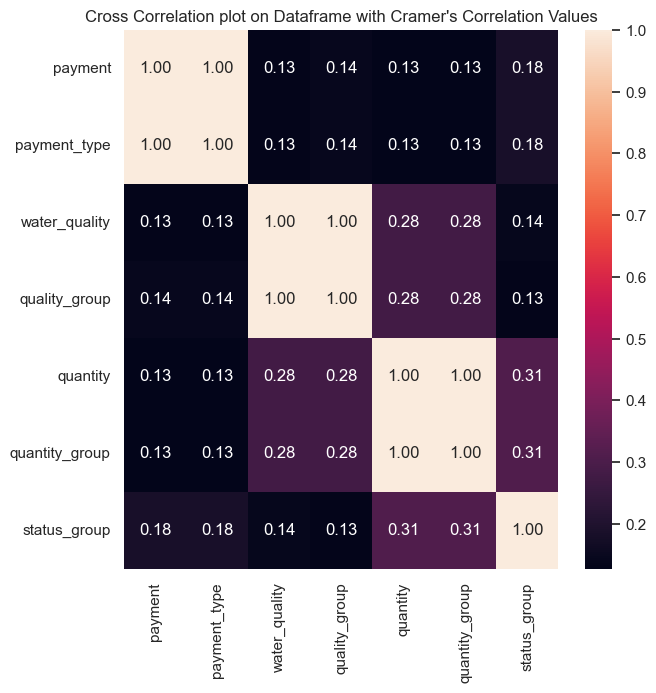

In [59]:
plot_cramer(df2)

### basin, region, source

In [60]:
features = ["basin", 
            "region",
            "source", 
            "status_group"]

df3 = train_data[features]
df3

,basin,region,source,status_group
0,Lake Nyasa,Iringa,spring,functional
1,Lake Victoria,Mara,rainwater harvesting,functional
2,Pangani,Manyara,dam,functional
3,Ruvuma / Southern Coast,Mtwara,machine dbh,non functional
4,Lake Victoria,Kagera,rainwater harvesting,functional
...,...,...,...,...
59395,Pangani,Kilimanjaro,spring,functional
59396,Rufiji,Iringa,river,functional
59397,Rufiji,Mbeya,machine dbh,functional
59398,Rufiji,Dodoma,shallow well,functional


In [61]:
chi_df3, pvalue_df3 = chi_square_test_on_functionality(df3)

pvalue_df3

(59400, 4)


,status_group
basin,0.0
region,0.0
source,0.0
status_group,0.0


Else condition Met:  1.0000000000000002
Else condition Met:  0.7670704036219047
Else condition Met:  0.2447122142419653
Else condition Met:  0.12663403694701172
Else condition Met:  0.7670704036219046
Else condition Met:  1.0
Else condition Met:  0.32155086935884364
Else condition Met:  0.20005871506460768
Else condition Met:  0.2447122142419653
Else condition Met:  0.32155086935884364
Else condition Met:  1.0
Else condition Met:  0.14811059560973563
Else condition Met:  0.12663403694701172
Else condition Met:  0.2000587150646077


C:\Users\Owner\AppData\Local\Temp\ipykernel_14316\2193547950.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramer.fillna(value=np.nan,inplace=True)


Else condition Met:  0.14811059560973563
Else condition Met:  0.9999999999999999


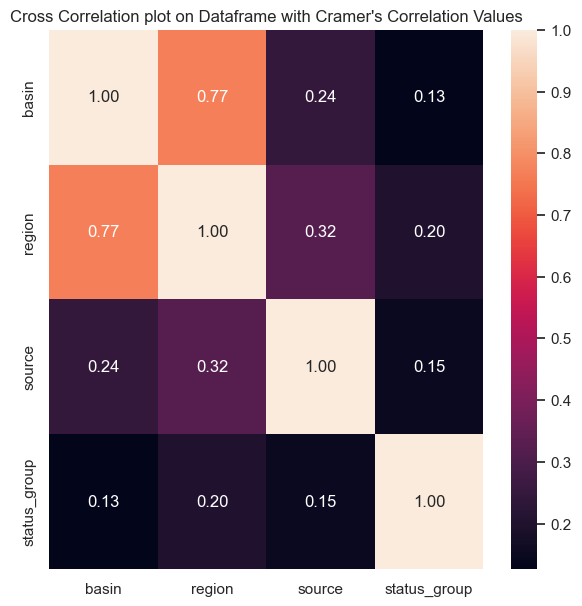

In [62]:
plot_cramer(df3)

### management and scheme management

In [63]:
features = ["management", "management_group",
            "scheme_management", "scheme_name",
            "status_group"]

df4 = train_data[features]
df4

,management,management_group,scheme_management,scheme_name,status_group
0,vwc,user-group,VWC,Roman,functional
1,wug,user-group,Other,NaN,functional
2,vwc,user-group,VWC,Nyumba ya mungu pipe scheme,functional
3,vwc,user-group,VWC,NaN,non functional
4,other,other,NaN,NaN,functional
...,...,...,...,...,...
59395,water board,user-group,Water Board,Losaa Kia water supply,functional
59396,vwc,user-group,VWC,Ikondo electrical water sch,functional
59397,vwc,user-group,VWC,NaN,functional
59398,vwc,user-group,VWC,NaN,functional


In [64]:
chi_df4, pvalue_df4 = chi_square_test_on_functionality(df4)

pvalue_df4

(59400, 5)


,status_group
management,0.000000e+00
management_group,1.744626e-57
scheme_management,0.000000e+00
scheme_name,0.000000e+00
status_group,0.000000e+00


Else condition Met:  1.0
Else condition Met:  0.9999410707445201
Else condition Met:  0.7939154602090793
Else condition Met:  0.7300909235953545
Else condition Met:  0.13165596946454589
Else condition Met:  0.9999410707445201
Else condition Met:  1.0
Else condition Met:  0.7000685668130384
Else condition Met:  0.6703921786099252
Else condition Met:  0.0485185288205425


C:\Users\Owner\AppData\Local\Temp\ipykernel_14316\2193547950.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cramer.fillna(value=np.nan,inplace=True)


Else condition Met:  0.7939154602090793
Else condition Met:  0.7000685668130384
Else condition Met:  1.0
Else condition Met:  0.7949172282102186
Else condition Met:  0.12964025756684971
Else condition Met:  0.7300909235953545
Else condition Met:  0.6703921786099252
Else condition Met:  0.7949172282102186
Else condition Met:  1.0000000000000002
Else condition Met:  0.5138291212261763
Else condition Met:  0.13165596946454589
Else condition Met:  0.04851852882054251
Else condition Met:  0.12964025756684971
Else condition Met:  0.5138291212261763
Else condition Met:  0.9999999999999999


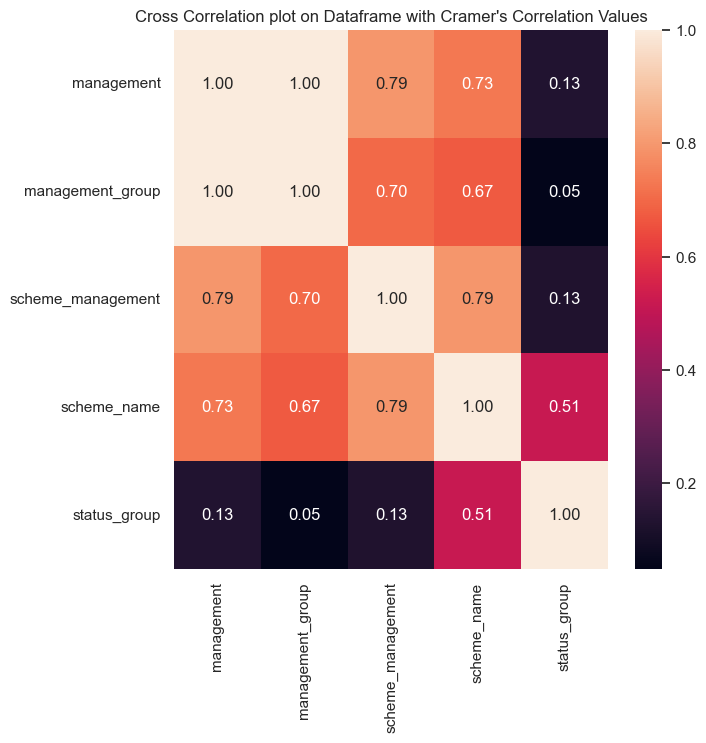

In [65]:
plot_cramer(df4)